## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
from torch import nn

## Load model

In [3]:
%run ../models/checkpoint/__init__.py

In [4]:
# run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
# run_name = '1215_222128_cxr14_mobilenet-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
run_name = '0324_123608_vinbig_precnn_densenet-121-v2_hint-lmb0.1-wbce_normD_size200_lr0.0001_sch-roc_auc-p20-f0.5_shuffle'
task = 'det'
debug_run = False

In [6]:
compiled_model = load_compiled_model_classification(run_name, debug=debug_run, task=task)
compiled_model.metadata['model_kwargs']

{'model_name': 'densenet-121-v2',
 'labels': ['Aortic enlargement',
  'Atelectasis',
  'Calcification',
  'Cardiomegaly',
  'Consolidation',
  'ILD',
  'Infiltration',
  'Lung Opacity',
  'Nodule/Mass',
  'Other lesion',
  'Pleural effusion',
  'Pleural thickening',
  'Pneumothorax',
  'Pulmonary fibrosis'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': [],
 'dropout': 0.3}

## Load data

In [6]:
%run ../datasets/__init__.py

In [7]:
dataset_kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'train',
    'max_samples': None,
    'labels': ['Cardiomegaly'],
    'masks': True,
    'image_size': (128, 128),
    'batch_size': 2,
    'masks_version': 'v1',
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

75708

## Train with HINT

### Prepare model

In [8]:
from torchviz import make_dot

In [9]:
%run ../training/classification/grad_cam.py
%run ../losses/__init__.py

In [10]:
# %run ../tensorboard/__init__.py
# run_name = 'hint'
# tb_writer = TBWriter(run_name, 'cls', debug=True)
# tb_writer.write_graph(model, data_batch.image.to(device))
# tb_writer.close()

In [11]:
class SimpleModel(nn.Module):
    def __init__(self, n_labels=14):
        super().__init__()

        self.features = nn.Conv2d(3, 10, 2)
        
        self.global_pool = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
        )
        
        self.prediction = nn.Linear(10, n_labels)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.prediction(x)
        
        return x

In [12]:
device = 'cuda'
training = True
multilabel = dataset.multilabel
multilabel

True

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
# hint_loss_fn = OutOfTargetSumLoss()
hint_loss_fn = nn.BCELoss()
# hint_loss_fn = WeigthedBCELoss(sigmoid=False)
# hint_loss_fn = lambda x, y: (x - y).mean() # Simple loss to debug

In [14]:
model, optimizer, _ = compiled_model.get_elements()
grad_cam = create_grad_cam(compiled_model.model)
grad_cam

In [15]:
model = SimpleModel(len(dataset.labels)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
grad_cam = LayerGradCam(model, model.features)
model

SimpleModel(
  (features): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
  (global_pool): Sequential(
    (0): AdaptiveMaxPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (prediction): Linear(in_features=10, out_features=1, bias=True)
)

### Run step_fn

To debug, copy here the `step_fn` from `training/classification/__init__.py`

In [23]:
def step_fn(data_batch, resize=True, norm=False, relu=False):
    images = data_batch.image.to(device)
    # shape: batch_size, channels=3, height, width

    labels = data_batch.labels.to(device)
    # shape(multilabel=True): batch_size, n_labels
    # shape(multilabel=False): batch_size

    masks = reduce_masks_for_diseases(dataset.labels, data_batch.masks.to(device))
    # shape: batch_size, n_labels, height, width

    # Enable training
    model.train(training)
    torch.set_grad_enabled(training)

    # zero the parameter gradients
    if training:
        optimizer.zero_grad()

    # Forward
    outputs = model(images)
    if isinstance(outputs, tuple):
        outputs = output_tuple[0]
    
    # outputs shape: batch_size, n_labels

    if multilabel:
        labels = labels.float()
    else:
        labels = labels.long()

    images.requires_grad = True
        
    grad_cam_attrs = calculate_attributions_for_labels(
        grad_cam, images, dataset.labels,
        relu=relu, create_graph=True,
        resize=resize, norm=norm,
    )
    # shape: (batch_size, n_labels, height, width)

    return grad_cam_attrs
    
    if not norm:
        grad_cam_attrs = torch.sigmoid(grad_cam_attrs)
    
    images.requires_grad = False

    # Compute HINT loss
    hint_loss = hint_loss_fn(grad_cam_attrs, masks.float())

    # Compute classification loss
    cl_loss = loss_fn(outputs, labels)
    
    total_loss = cl_loss + hint_loss
    
    if training:
        total_loss.backward()
        optimizer.step()

    return cl_loss, hint_loss, total_loss, images, grad_cam_attrs
        
    # print(hint_loss.item(), loss.item())

    # return total_loss

In [17]:
data_batch = next(iter(dataloader))
data_batch.image.size(), data_batch.masks.size()

(torch.Size([2, 3, 128, 128]), torch.Size([2, 4, 128, 128]))

In [18]:
cl_loss, hint_loss, total_loss, i, gcam = step_fn(data_batch)
cl_loss.item(), hint_loss.item(), total_loss.item(), gcam.size()

(0.45970094203948975,
 0.6931483745574951,
 1.1528493165969849,
 torch.Size([2, 1, 128, 128]))

In [24]:
gcam = step_fn(data_batch)
gcam.size()

torch.Size([2, 1, 128, 128])

In [19]:
def _print_grads(model):
    print(model.features.weight.grad.mean())
    print(model.features.bias.grad.mean())
    print(model.prediction.weight.grad.mean())
    print(model.prediction.bias.grad.mean())

In [20]:
_print_grads(model)

tensor(0.0083, device='cuda:0')
tensor(-0.0127, device='cuda:0')
tensor(-0.5247, device='cuda:0')
tensor(-0.3685, device='cuda:0')


In [25]:
gcam.min(), gcam.max()

(tensor(-1.2411e-05, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.1509e-05, device='cuda:0', grad_fn=<MaxBackward1>))

In [28]:
g = (gcam * 10000)
g.min(), g.max()

(tensor(-0.1241, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2151, device='cuda:0', grad_fn=<MaxBackward1>))

In [20]:
params = dict(model.named_parameters())
params['images'] = i

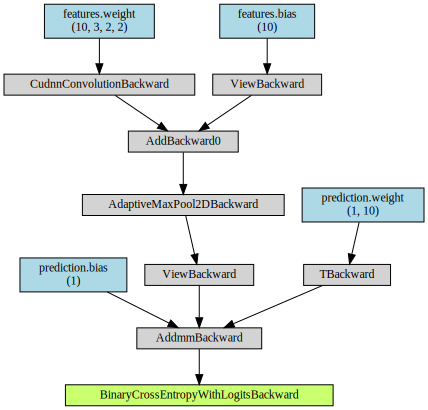

In [63]:
make_dot(cl_loss, params=params)

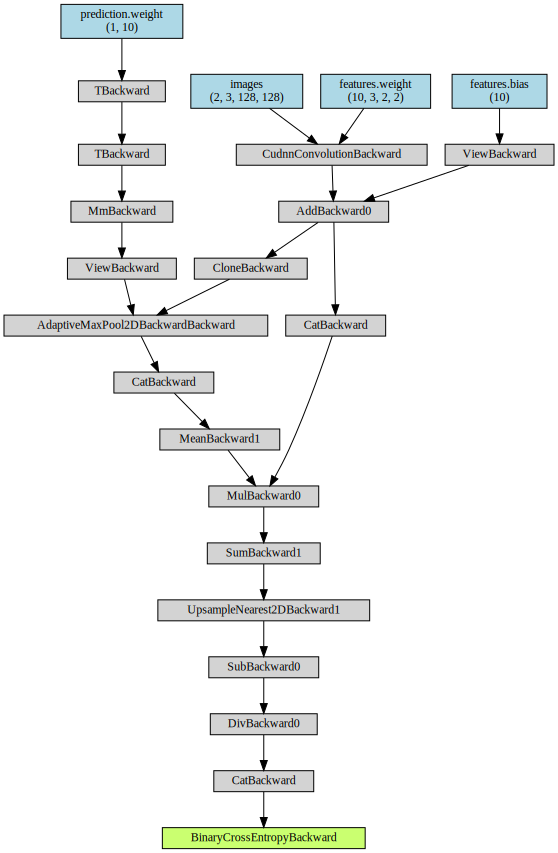

In [21]:
make_dot(hint_loss, params=params)

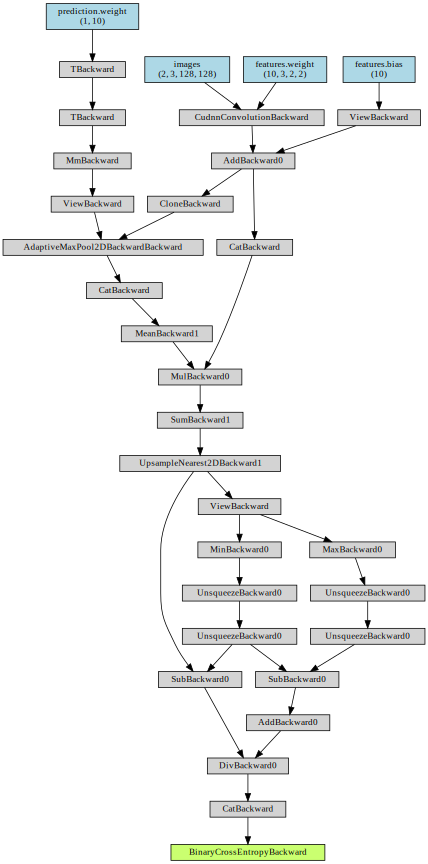

In [66]:
make_dot(hint_loss, params=params)

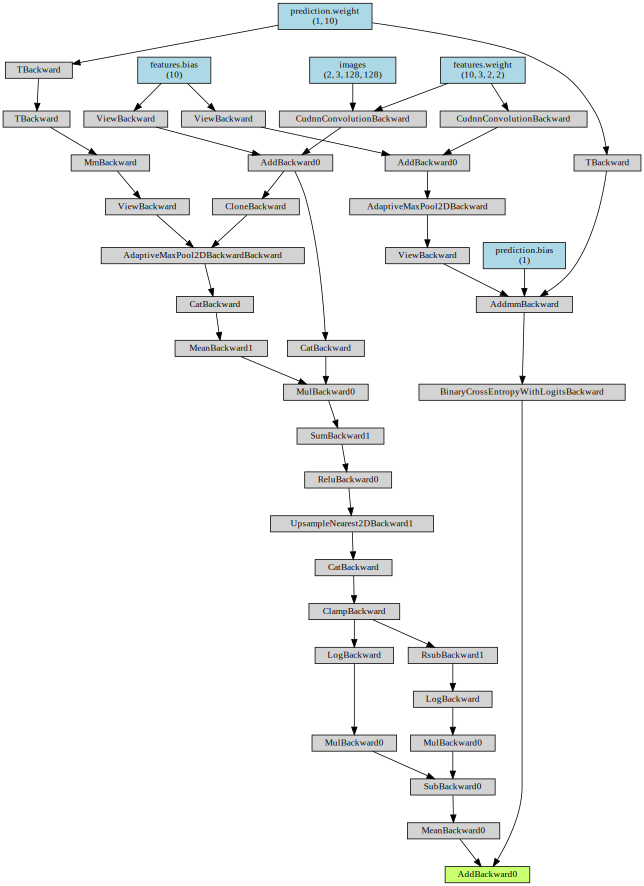

In [41]:
make_dot(total_loss, params=params)